# Parte 5. Análisis de datos interactivo

## Introducción


Este notebook introduce el análisis de datos interactivo de datos en BigQuery
utilizando un notebook de Jupyter gestionado por Vertex AI Workbench, el
cual es un entorno basado en notebooks de Jupyter que se proporciona a
través de instancias de máquina virtual (VM) con funciones que admiten
todo el flujo de trabajo de la ciencia de datos.

Puedes usar el entorno basado en notebooks de Vertex AI Workbench para
consultar y explorar datos, desarrollar y entrenar un modelo, y ejecutar
tu código como parte de un pipeline (canalización).

Esta celda, por ejemplo, es una celda de markdown. Es por eso que estás
viendo texto. La celda que sigue es una celda de código Python. La salida
de esa celda es lo que se imprime desde ella.

In [ ]:
a = 3
b = a + 5
print(f"a={a} b={b}")

## Ruta relativa


Este notebook se creó en la carpeta 05_bqnotebook del repositorio de git.
Por lo tanto, es posible que veas una ruta que termine en eso. Pero la ruta
comenzará con /home/jupyter, que está mapeada a una carpeta local si se
ejecuta en un contenedor, de otro modo si estas en tu dispositivo local
veras la ruta local al archivo

In [ ]:
!pwd

## ¿Qué está instalado?


¿Usamos !pip o %pip?

La primera opción ejecuta el comando en la shell y si no tenemos activado el ambiente ahi podría darnos resultados errados.

La segunda opción ejecuta pip por una función mágica, la cual ejecuta el
gestor de paquetes dentro del kernel(núcleo) actual 

In [ ]:
%pip freeze

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from google.cloud import bigquery
from scipy.interpolate import interp1d
%load_ext google.cloud.bigquery

## Instalando dependencias

Las dependencias de Python regulares se pueden instalar utilizando pip

In [ ]:
%pip install pytz

## Juypter magic

In [ ]:
%%html
Esta celda imprimirá un `string` de <b> HTML </b>.

El cell magic `%%bigquery` nos retorna los resultados de la consulta en
SQL en un DataFrame de pandas.


El sintaxis de la celda mágica es el siguiente:

```
%%bigquery [<destination_var>] [--project <project>] [--use_legacy_sql]
           [--verbose] [--params <params>] <query>
```

Obs. si nos encontramos en un ambiente local, antes de ejecutar la celda
debemos ejecutar la linea mágica load_ext la cual carga las funciones
mágicas por su nombre de módulo.

In [ ]:
%load_ext google.cloud.bigquery

In [ ]:
%%bigquery
SELECT
    COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM
    dsongcp.flights_tzcorr

## Acceso a llamadas a BigQuery

También podemos realizar llamadas a BigQuery directamente con la biblioteca
de Python:

In [ ]:
bq = bigquery.Client()

In [ ]:
sql = """
SELECT
  COUNTIF(arr_delay >= 15)/COUNT(arr_delay) AS frac_delayed
FROM dsongcp.flights_tzcorr
"""
bq.query(sql).to_dataframe()

Grafiquemos una Función de Distribución de Probabilidad (PDF o Probability
Distribution Function) de diferentes retrasos de llegada. En un Notebook,
podemos asignar la salida de una consulta de la celda mágica a una variable,
en este caso df, como vimos en la sintáxis de la celda mágica %%biggquery:

In [ ]:
%%bigquery df
SELECT
    ARR_DELAY, DEP_DELAY
FROM
    dsongcp.flights_tzcorr
WHERE
    DEP_DELAY >= 10

In [ ]:
type(df)

In [ ]:
df.describe()

In [ ]:
# predefined style {darkgrid=Default, whitegrid, dark, white, ticks}
sns.set_style(style="whitegrid")
# sns.set_theme(font_scale=1.5)  # Default font_scale=1
ax = sns.violinplot(data=df, x="ARR_DELAY", inner="box", orient="h")
ax.axes.set_xlim(-50, 300)

## Visualizando distribuciones

In [ ]:
%%bigquery df
SELECT ARR_DELAY, DEP_DELAY
FROM dsongcp.flights_tzcorr

In [ ]:
df.describe()

In [ ]:
df['ontime'] = df['DEP_DELAY'] < 10
df[df['ARR_DELAY'] > 0].head()

In [ ]:
sns.set_style("whitegrid")
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', inner='box', orient='h')
ax.set_xlim(-50, 200);

Podemos modificar el argumento gridsize, el cual es el número de puntos
en la malla discreta usada para evaluar la estimación de densidad del kernel
para obtener un gráfico mas "suave" a cambio de un mayor tiempo.

In [ ]:
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime', 
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 200)

## Valores atípicos

La siguiente consulta nos entrega el retraso de llegada promedio y el numero
de vuelos, asociados con cada valor de retraso de llegada

In [ ]:
%%bigquery depdelay
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
ORDER BY
    DEP_DELAY

El número de registros de cada grupo lo vemos a continuación

In [ ]:
len(depdelay)

Obtenemos mas de 1800 valores únicos, esto quiere decir que algo pasa con los
datos y tenemos valores fuera de lo común.

In [ ]:
depdelay[:5]

In [ ]:
depdelay[55:60]

Las primeras filas tienen pocos vuelos, sin embargo los valores de retraso
pequeños tienen cantidades considerables, los valores poco comunes que
son una proporción pequeña con respecto al total de los datos pueden ser
probablemente ignorados sin afectar a nuestro modelo.

## Descartando valores atípicos


Como remover dichos valores atípicos? Hay dos grandes maneras para filtrar
los datos, una sería basado en la variable dep_delay (retraso de salida)
manteniendo solo los valores que cumplen una condición, por ejemplo
dep_delay > -15. Un segundo método sería filtrar los datos basado en el
numero de vuelos.

El segundo método usar un filtro de control de calidad que está basado
en remover datos para los cuales tenemos ejemplos insuficientes es preferible.

Obs. Este es un punto importante que destaca la diferencia clave entre la
estadística en conjuntos de datos "normales" y la estadística en grandes
conjuntos de datos. El enfoque fundamental para abordar problemas cambia cuando
los conjuntos de datos crecen lo suficiente. La forma en que detectamos valores
atípicos es solo un ejemplo de esto.

Por ejemplo para conjuntos de datos que tienen cientos o miles de ejemplos,
filtraríamos valores fuera de $\mu \pm 3 \sigma$ (donde $\mu$ es la media y
$\sigma$ es la desviación estándar)

In [ ]:
%%capture
%%bigquery limits
SELECT
    AVG(DEP_DELAY) - 3*STDDEV(DEP_DELAY) AS filter_min,
    AVG(DEP_DELAY) + 3*STDDEV(DEP_DELAY) AS filter_max
FROM
    dsongcp.flights_tzcorr;

In [ ]:
limits

Esto nos lleva al rango de $[-157, 185]$ minutos por ende podriamos filtrar con una sentencia `WHERE dep_delay BETWEEN -157 AND 185`.

Obs. Este filtro está basado en el supuesto de que la distribución de los
retrasos de vuelos es "Normal" (Gaussiana).

Otro ejemplo que evita este supuesto, sería usar percentiles omitiendo algún
porcentaje de los datos digamos 5% de los valores mas altos y bajos.

In [ ]:
%%capture
%%bigquery quantiles
SELECT
APPROX_QUANTILES(DEP_DELAY, 20)
FROM
dsongcp.flights_tzcorr;

El DataFrame devuelto por bigquery es de una fila y una columna, su contenido
es un array de 21 floats que contienen los 20 cuantiles aproximados, calculados
por la función `APPROX_QUANTILES` para `DEP_DELAY` por ende consideramos el
segundo y penúltimo elemento del array.

In [ ]:
quantiles.iat[0,0]

Por lo tanto el intervalo entregado por este filtro es $[-10,83]$

En conclusión en conjuntos de datos que contienen cientos de miles a millones
de ejemplos, establecer umbrales en los datos de entrada según su valor es
peligroso porque puedes estar descartando matices valiosos. Si hay suficientes
ejemplos de un retraso de 150 minutos, vale la pena modelar dicho valor
independientemente de lo lejos que esté de la media. A medida que nuestro
conjunto de datos vaya creciendo los valores particulares se van haciendo menos
frecuentes.

## Filtrado de datos por frecuencia de ocurrencia

Para filtrar el conjunto de datos basado en la frecuencia de ocurrencia,
primero necesitamos calcular la frecuencia de ocurrencia y luego aplicar
un umbral a los datos en función de esta.

In [ ]:
%%capture
%%bigquery occ
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arr_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING
    numflights > 370
ORDER BY
    DEP_DELAY


In [ ]:
occ.head()


¿Por qué establecer un umbral de 370 vuelos? Este número se obtiene de una guía
llamada regla de los tres sigmas, que tradicionalmente es el rango dentro del
cual consideramos que "casi todos los valores" se encuentran. Si asumimos (por
ahora; lo verificaremos pronto) que, para cualquier retraso de salida, los
retrasos de llegada están distribuidos normalmente, podemos hablar de hechos que
son verdaderos para "casi todos los vuelos" si nuestro tamaño de población es
lo suficientemente grande. Debido a que el 99.73% de los valores en una
distribución gaussiana se encuentran dentro de los límites de tres sigmas,
filtrar nuestro conjunto de datos para que tengamos al menos $1/(1 - 0,9973)=370$
ejemplos de cada valor de entrada es una regla general que logra esto.

### ¿Que tan distintos son los resultados si consideramos un umbral distinto?

Podemos ver el numero de vuelos que son removidos según diferentes umbrales
de control de calidad, observando la pendiente del modelo lineal entre el
retraso de llegada y el retraso de salida.

Obs. Estrictamente no es un modelo lineal si no que una simplificacion de este
ya que hay supuestos con respecto al error e intercepto.

In [ ]:
%%capture
%%bigquery df
DECLARE total_flights INT64;
SET total_flights = (
    SELECT COUNT(*) FROM dsongcp.flights_tzcorr
);

CREATE TEMPORARY FUNCTION linear_fit(NUM_TOTAL INT64, THRESH INT64)
RETURNS STRUCT<thresh INT64, num_removed INT64, lm FLOAT64>
AS ((
    SELECT AS STRUCT
        THRESH,
        (NUM_TOTAL - SUM(numflights)) AS num_removed,
        ROUND(AVG(arrival_delay * numflights) / AVG(dep_delay * numflights), 2) AS lm
    FROM
    (
        SELECT
            DEP_DELAY,
            AVG(ARR_DELAY) AS arrival_delay,
            STDDEV(ARR_DELAY) AS stddev_arrival_delay,
            COUNT(ARR_DELAY) AS numflights
        FROM
            dsongcp.flights_tzcorr
        GROUP BY
            DEP_DELAY
    )
    WHERE numflights > THRESH
))
;

SELECT linear_fit(total_flights, 1000) stats
UNION ALL SELECT linear_fit(total_flights, 500)
UNION ALL SELECT linear_fit(total_flights, 370)
UNION ALL SELECT linear_fit(total_flights, 300)
UNION ALL SELECT linear_fit(total_flights, 200)
UNION ALL SELECT linear_fit(total_flights, 100)
UNION ALL SELECT linear_fit(total_flights, 22)
UNION ALL SELECT linear_fit(total_flights, 10)
UNION ALL SELECT linear_fit(total_flights, 5)
ORDER BY stats.thresh DESC

In [ ]:
df['stats'].map(lambda x: (x['thresh'], x['num_removed'], x['lm']))

Podemos ver que la pendiente disminuye cada vez menos a medida que disminuimos
el umbral. Por lo tanto las diferencias en el modelo creado los umbrales de 300
, 370 o 500 son bastante menores. sin embargo el modelo es bastante diferente
si los umbrales fuesen 5 o 10 vuelos. El orden de magnitud del umbral importa
quizás no tanto su valor exacto.

##  Retraso de llegada condicionado en retraso de salida.

Ya que tenemos la consulta que selecciona los valores que tienen un número
ejemplos aceptable según lo visto en la sección anterior.

En la parte 3, nuestro modelo construido se basada simplemente en seleccionar
los valores en base a un umbral. ahora sin embargo vemos  que hay muchos vuelos
para cada retraso de salida dado. entonces queremos responder:

¿Dado un retraso de salida cual es el retraso de llegada probable?

### distribución de los retrasos de llegada.

In [2]:
%%bigquery normal_dep_delay
SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING numflights > 370
ORDER BY DEP_DELAY

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
normal_dep_delay[:5]

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-25.0,-25.495192,12.443800,416
1,-24.0,-25.099650,12.922734,572
2,-23.0,-25.559477,11.686600,765
3,-22.0,-23.580131,13.293409,1067
4,-21.0,-22.670732,13.014263,1394


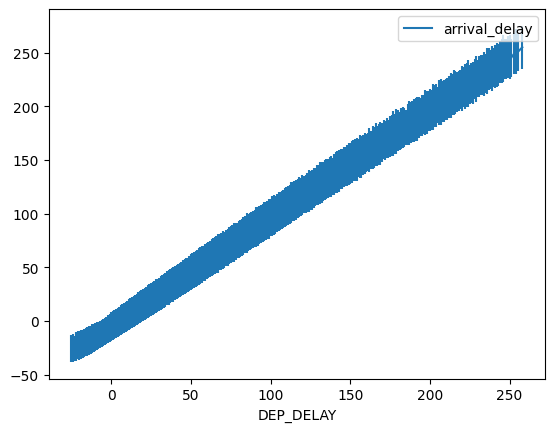

In [4]:
ax = normal_dep_delay.plot(
    kind="line", x="DEP_DELAY", y="arrival_delay", yerr="stddev_arrival_delay"
)

El gráfico anterior parece que la relación entre los retrasos de salida y de
llegada fuese linear. También podemos obserbar que el error tambien está dentro
del mismo orden de magnitud (10 min).

### Aplicando un umbral de decisión probabilístico.

Recordemos que nuestro criterio de desición es que, si el avión tiene una
probabilidad mayor al 30% de llegar tarde por más de 15 minutos, queremos
enviar el mensaje para posponer la reunión. La pregunta es ¿Para qué valor de
retraso de salida pasa esto?

Al calcular la desviación estándar de los retrasos de llegada correspondiente
a cada retraso de salida, implícitamente estamos asumiendo que los retrasos de
llegada se distribuyen de manera normal. Por ahora continuamos con este supuesto.

Podemos revisar una tabla de distribución acumulada para encontrar un valor tal
que la probabilidad de que $Z$ sea menor o igual a $0.7$ ($Prob(Z\le 0.7)$) o
usar una tabla de distribución acumulada complementaria para encontrar un valor
tal que la probabilidad de $Z$ sea mayor que $0.3$ ($Prob(Z>0.3)$) y para ambos
casos encontramos que $Z=0.52$. Por lo tanto como el valor encontrado
corresponde a una distribución normal estándar, podemos obtener nuestra distribución usando $X = \dfrac{X-\mu}{\sigma}$.

Obs. Con respecto a la primera opción de las tablas, tenemos para $Z=0.52$ el
valor de $0.6985$ y para $Z=0.53$ el valor de $0.7019$.

In [5]:
# Definimos "arr_delay_30"
Z_30 = 0.52
normal_dep_delay["arr_delay_30"] = (
    Z_30 * normal_dep_delay["stddev_arrival_delay"]
) + normal_dep_delay["arrival_delay"]
# Interpolamos el valor de x que corresponde a y=15
f = interp1d(normal_dep_delay["arr_delay_30"], normal_dep_delay["DEP_DELAY"])
print(f"El valor de x para y=15 es: {f(15)}")
# Seleccionamos los valores cercanos +-1
normal_dep_delay[
    (normal_dep_delay["DEP_DELAY"] >= np.floor(f(15)))
    & (normal_dep_delay["DEP_DELAY"] <= np.ceil(f(15) + 1))
]

El valor de x para y=15 es: 12.709664561044978


,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights,arr_delay_30
37,12.0,6.920823,14.205193,56847,14.307523
38,13.0,7.855299,14.284624,52923,15.283304
39,14.0,8.899727,14.311200,50193,16.341551


Antes de graficar vemos que el valor de "DEP_DELAY" = 13 es el que está mas
cerca del valor de "arr_delay_30" = 15. Ya que al interpolar de manera lineal
estamos suponiendo que la relacion entre las variables es así.

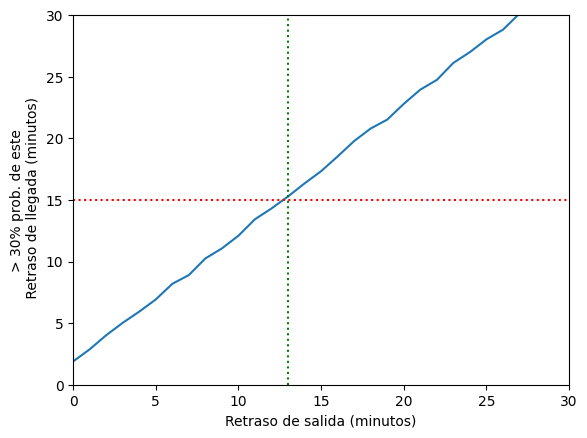

In [6]:
ax = plt.axes()
normal_dep_delay.plot(
    kind="line",
    x="DEP_DELAY",
    y="arr_delay_30",
    ax=ax,
    ylim=(0, 30),
    xlim=(0, 30),
    legend=False,
)
ax.set_xlabel("Retraso de salida (minutos)")
ax.set_ylabel("> 30% prob. de este\n Retraso de llegada (minutos)")

ax.axhline(y=15, color="r", linestyle="dotted")
ax.axvline(x=13, color="g", linestyle="dotted");

### Función de distribución empírica.

Para eliminar el supuesto de normalidad debemos calcular empíricamente la
probabilidad del 30% en cada retraso de salida.

In [7]:
%%bigquery quantile_dep_delay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 100)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
GROUP BY
    DEP_DELAY
HAVING
    numflights > 370
ORDER BY
    DEP_DELAY

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
# Interpolamos el valor de x que corresponde a y=15
f = interp1d(
    quantile_dep_delay["arrival_delay"], quantile_dep_delay["DEP_DELAY"]
)
print(f"El valor de DEP_DELAY para arrival_delay = 15 es: {f(15)}")
# Seleccionamos el valor
quantile_dep_delay[(quantile_dep_delay["DEP_DELAY"] == f(15))]

El valor de DEP_DELAY para arrival_delay = 15 es: 16.0


,DEP_DELAY,arrival_delay,numflights
41,16.0,15.0,44556


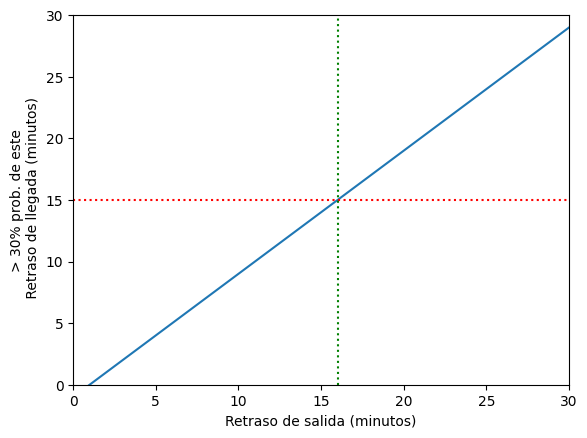

In [10]:
ax = plt.axes()
quantile_dep_delay.plot(
    kind="line",
    x="DEP_DELAY",
    y="arrival_delay",
    ax=ax,
    ylim=(0, 30),
    xlim=(0, 30),
    legend=False,
)
ax.set_xlabel("Retraso de salida (minutos)")
ax.set_ylabel("> 30% prob. de este\n Retraso de llegada (minutos)")

ax.axhline(y=15, color="r", linestyle="dotted")
ax.axvline(x=16, color="g", linestyle="dotted");

## Creando el dataset de  entrenamiento/evaluación.

¿Que tan bueno es nuestro modelo? ¿cuantas veces nuestro consejo de cancelar o
no será el correcto?

Existen dos enfoques generales para encontrar una muestra independiente:

1. Recopilar nuevos datos, por ejemplo podríamos descargar más datos de la BTS
  y evaluar nuestra recomendación en esos nuevos datos.

2. Separar nuestros datos actuales en dos partes. Creamos el modelo en la
  primera parte (llamado el conjunto de datos de entrenamiento) y evaluarlo
  en la segunda parte (llamado conjunto de datos de evaluación o prueba).

El segundo enfoque es el más común cuando tenemos un conjunto de datos finito.
Para crear dicho conjunto ejecutamos ya sea el script de bash en la carpeta
actual o el de python en la carpeta local.

Al separar nuestros datos debemos ser cuidadosos, ya que queremos asegurar que
ambas partes sean representativas del conjunto de datos completo y tengan
relaciones similares a lo que queremos predecir. Pero a la vez también queremos
asegurarnos de que el conjunto de datos de prueba sea independiente de el de
entrenamiento.

Para entender esto separaremos el conjunto de dos diferentes maneras.

### Mezcla aleatoria.

Podríamos dividir los datos mezclando aleatoriamente todas las filas del
conjunto de datos y eligiendo el primer 70% como conjunto de entrenamiento y el
30% restante como conjunto de prueba. En BigQuery, puedes hacerlo utilizando la
función RAND():

In [ ]:
%%bigquery shuffle_dep_delay
SELECT
    ORIGIN,
    DEST,
    DEP_DELAY,
    ARR_DELAY
FROM
    dsongcp.flights_tzcorr
WHERE
    RAND() < 0.7

La función RAND devuelve un valor entre 0 y 1, entonces aproximadamente el 70%
de los datos serán seleccionados en esta consulta. Sin embargo existen varios
problemas al usar este método de muestreo para machine learning.

- No es fácil obtener el resto de las filas que no fueron seleccionadas en el
  conjunto de entrenamiento.

- La función RAND nos devuelve diferentes valores cada vez que es ejecutada, entonces si ejecutamos la consulta nuevamente obtendremos un 70% de filas diferentes.

- El orden de las filas en un resultado de BigQuery no está garantizado, esto
  tiene que ver con el orden en que los nodos retornan sus resultados. Entonces
  aunque pudiésemos establecer que RAND fuese replicable aun no obtendríamos
  resultados replicables.

- Tenemos que ordenar los datos antes de llamar a RAND, esto no será siempre posible.

### Separar por fecha.

En este enfoque encontraremos las fechas únicas en el conjunto de datos, las
mezclamos y usamos el 70% de esos días como conjunto de entrenamiento y los
restantes como evaluación.

In [11]:
%%bigquery unique_days
SELECT
    DISTINCT(FL_DATE) AS FL_DATE
FROM
    dsongcp.flights_tzcorr
ORDER BY
    FL_DATE

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
unique_days[:5]

,FL_DATE
0,2022-11-01
1,2022-11-02
2,2022-11-03
3,2022-11-04
4,2022-11-05


In [17]:
%%bigquery train
SELECT
    FL_DATE,
    FARM_FINGERPRINT(CAST(FL_DATE AS STRING)) date_hash,
    MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100) as mod_date_hash,
    ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) as abs_mod_date_hash,
    IF(
        ABS(MOD(FARM_FINGERPRINT(CAST(FL_DATE AS STRING)), 100)) < 70,
        'True',
        'False'
    ) AS is_train_day
FROM
    (
        SELECT
            DISTINCT(FL_DATE) AS FL_DATE
        FROM
            dsongcp.flights_tzcorr
    )
ORDER BY
    FL_DATE

Query is running:   0%|          |

Downloading:   0%|          |

In [18]:
train[:5]

,FL_DATE,date_hash,mod_date_hash,abs_mod_date_hash,is_train_day
0,2022-11-01,-7701120425202279183,-83,83,False
1,2022-11-02,-4951538389414126586,-86,86,False
2,2022-11-03,-8383072635110010971,-71,71,False
3,2022-11-04,-2554333180643815737,-37,37,True
4,2022-11-05,4675668428541175032,32,32,True


En la consulta anterior utilizamos FARM_FINGERPRINT para calcular el valor de
hash (para identificar los días de manera única) y utilizando la función MOD
obtenemos los 2 últimos dígitos, como el hash puede ser negativo utilizamos la función ABS, para finalmente comparar todos los resultados (desde 0 a 99)
con el porcentaje de entrenamiento (en este caso 70).

### Entrenando y evaluando.

In [19]:
%%bigquery train_dep_delay
SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY, 100)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
FROM
    dsongcp.flights_tzcorr
JOIN
    dsongcp.trainday USING(FL_DATE)
WHERE
    is_train_day = 'True'
GROUP BY
    DEP_DELAY
HAVING
    numflights > 370
ORDER BY
    DEP_DELAY

Query is running:   0%|          |

Downloading:   0%|          |

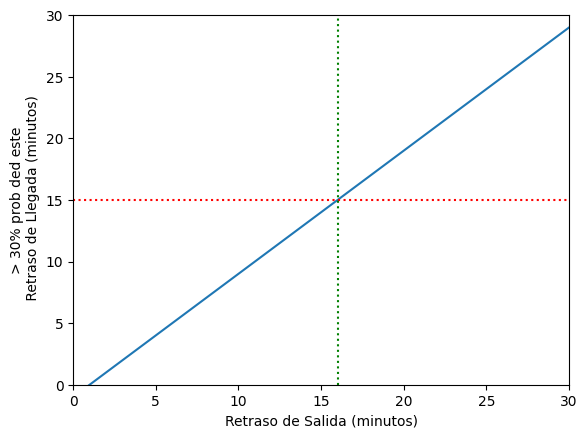

In [21]:
ax = plt.axes()
train_dep_delay.plot(
    kind="line",
    x="DEP_DELAY",
    y="arrival_delay",
    ax=ax,
    ylim=(0, 30),
    xlim=(0, 30),
    legend=False,
)
ax.set_xlabel('Retraso de Salida (minutos)')
ax.set_ylabel('> 30% prob de este\n Retraso de Llegada (minutos)');

ax.axhline(y=15, color="r", linestyle="dotted")
ax.axvline(x=16, color="g", linestyle="dotted");

Evaluando la recomendación.

In [22]:
%%bigquery df_eval
SELECT
    SUM(IF(DEP_DELAY < 16
        AND arr_delay < 15, 1, 0)) AS correct_nocancel,
    SUM(IF(DEP_DELAY < 16
        AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
    SUM(IF(DEP_DELAY >= 16
        AND arr_delay < 15, 1, 0)) AS wrong_cancel,
    SUM(IF(DEP_DELAY >= 16
        AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM
    (
        SELECT
            DEP_DELAY,
            ARR_DELAY
        FROM
            dsongcp.flights_tzcorr
        JOIN dsongcp.trainday USING(FL_DATE)
        WHERE
            is_train_day = 'False'
    )

Query is running:   0%|          |

Downloading:   0%|          |

In [25]:
df_eval

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,1548016,100038,78671,353509


In [30]:
precision = df_eval["correct_nocancel"] / (
    df_eval["correct_nocancel"] + df_eval["wrong_nocancel"]
);

specificity = df_eval["correct_cancel"] / (
    df_eval["correct_cancel"] + df_eval["wrong_cancel"]
);

print(f"precision = {precision[0]}")
print(f"specificity = {specificity[0]}")

precision = 0.9392993190757098
specificity = 0.8179670507658846


In [31]:
%%bigquery eval
SELECT
    SUM(IF(DEP_DELAY = 15
        AND arr_delay < 15, 1, 0)) AS correct_nocancel,
    SUM(IF(DEP_DELAY = 15
        AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
    SUM(IF(DEP_DELAY = 16
        AND arr_delay < 15, 1, 0)) AS wrong_cancel,
    SUM(IF(DEP_DELAY = 16
        AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM
    (
        SELECT
            DEP_DELAY,
            ARR_DELAY
        FROM
            dsongcp.flights_tzcorr
        JOIN dsongcp.trainday USING(FL_DATE)
        WHERE is_train_day = 'False' 
    )

Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
eval

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,10857,4369,9578,4328


In [33]:
print(
    eval["correct_nocancel"]
    / (eval["correct_nocancel"] + eval["wrong_nocancel"])
)
print(eval["correct_cancel"] / (eval["correct_cancel"] + eval["wrong_cancel"]))

0    0.713057
dtype: Float64
0    0.311233
dtype: Float64
